## Decission Trees

In [8]:
# Importamos paquetes
import pandas as pd
import numpy as np
import matplotlib
import scipy as sp
import matplotlib.pyplot as plt
import mglearn

### Construcción de árboles de decisión
Usemos ahora el método `make_moons` de Scikit-Learn para ilustrar gráficamente con un dataset de más puntos la construcción de un árbol de decisión, que también nos ayudará a revelar algunas de sus características:

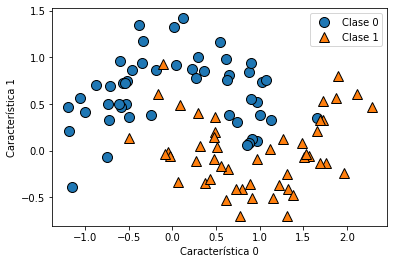

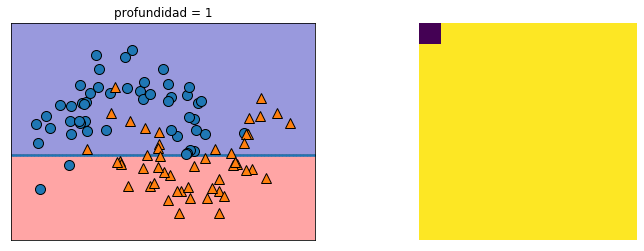

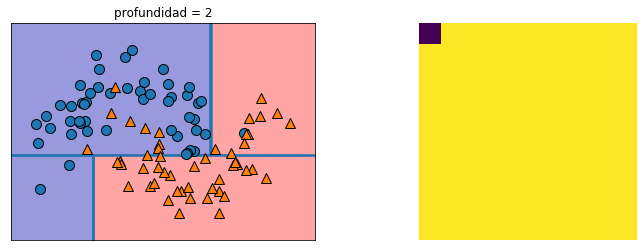

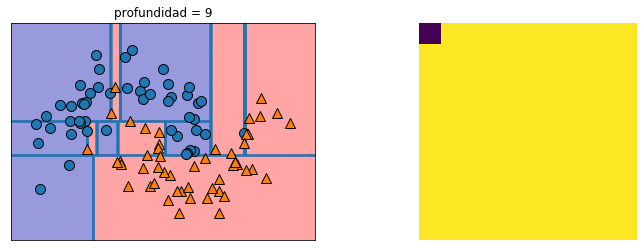

In [2]:
mglearn.plots.plot_tree_progressive()


Se repite el particionado recursivo de datos hasta que cada región, que coincide con un hoja del árbol, sólo contiene una variable objetivo (una sola clase o un sólo valor de regresión).

Para realizar una predicción sobre una nueva muestra, se mira en qué región cae. La predicción mayoritaria ahí es la que determina el valor de la predición. El mismo proceso se sigue si se recorre el árbol desde la raíz y yendo a izqda o derecha dependiendo del cumplimiento de la condición expresada en el nodo.

### Control de la precisión de los árboles de decisión

Todo este proceso, como puede intuirse, conduce a la construcción de árboles que son complejos y que sobreajustan mucho los datos de entrenamiento. El hecho de que existan hojas puras indica que el árbol es 100% preciso sobre el training set: cada punto de datos del mismo es una hoja que contiene a la clase mayoritaria correcta. Este sobreajuste se apreciaba bien en la figura anterior (áreas verticales finas de una clase en mitad de un área más grande de la otra clase).

El tipo de fronteras de decisión así configuradas no es de la clase que uno se esperaría encontrar; hay demasiado foco en outliers y poco en elaborar un borde con un buen grado de generalización.

Dos de las estrategias más comunes para evitar el sobreajuste son:

 - **Pre-prunning**: consiste en parar anticipadamente la construcción del árbol, por ejemplo limitando la profundidad máxima del árbol, el número máximo de hojas, o requerir la presencia de un número mínimo de muestras en un nodo para poder seguir adelante.
 - **Post-prunning**, o simplemente **prunning**: consiste en construir el árbol completo, pero eliminar posteriormente nodos que contienen poca información.

Los árboles de decisión se implementan en Scikit-Learn con las clases `DecisionTreeRegressor` y `DecisionTreeClassifier`. classes. Scikit-learn sólo implementa estrategias de pre-pruning.


Vamos a echar un vistazo al efecto del pre-prunning en más detalle en nuestro dataset de cáncer de mama. En principio, usamos la configuración por defecto para construir el árbol completo, que implica su crecimiento hasta que todas las hojas son puras.

In [1]:
# Importar un DecisionTreeClassifier desde el módulo tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Cargar el Breast Cancer Dataset
cancer = load_breast_cancer()

# Partir el dataset alrededor del target
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify = cancer.target,
                                                    random_state = 42)

# Instanciar un modelo y entrenarlo
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(X_train, y_train)

# Evaluarlo
print("Precisión en el training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Precisión en el test set: {:.3f}".format(tree.score(X_test, y_test)))

# Se ve que hace un overfitting total, entonces vamos a limitar esto haciendo un pre-running

Precisión en el training set: 1.000
Precisión en el test set: 0.923


Como esperábamos, la precisión sobre el training set es del 100%. Ya que todas las hojas son puras, el modelo ha memorizado todos los datos. La precisión sobre el test set es un poco peor que en los modelos lineales que ya hemos visto, en los que alcanzábamos alrededor del 95%.

Si no restringiesemos la profundidad, el árbol se volvería innecesariamente profundo y complejo, y eso no generalizaría bien los datos. Si hacemos pre-prunning, pararemos el desarrollo del árbol antes de que los datos se memoricen.

Una de las opciones que hemos comentado es limitar la profundidad máxima. Vamos a fijar el parámetro max_depth=4, haciendo que sólo se hagan cuatro decisiones. La precisión de entrenamiento bajará, sin duda, pero a cambio de un incremento de la precisión en test:

In [2]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0) #Aquí ponemos 4 árboles
tree.fit(X_train, y_train)

print("Precisión en el training set: {:.3f}"
      .format(tree.score(X_train, y_train)))
print("Precisión en el test set: {:.3f}"
      .format(tree.score(X_test, y_test)))

# Parece que merece la pena aunque parezca poco, además que es bueno cortar el árbol

Precisión en el training set: 0.988
Precisión en el test set: 0.951


### Análisis de los árboles de decisión

Podemos visualizar el árbol utilizando la función `export_graphviz` incluida en el módulo `tree`. Esta función graba el árbol en un fichero de tipo `.dot`, que es un formato texto para describir árboles.

Usamos una opción para colorear los nodos para reflejar la clase mayoritaria en cada uno y le pasamos los nombres de clases y caracterísitcas:

In [3]:
#Tuve que instalar el paquete graphviz antes así en terminal: brew install graphviz
import graphviz
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", 
                class_names=["maligno", "benigno"],
                feature_names=cancer.feature_names,
                impurity=False, filled=True)

ModuleNotFoundError: No module named 'graphviz'

Por último, leemos el fichero y los visualizamos para representar el árbol:

In [4]:
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# Se ve que se interpreta bien, pero cortariamos un poco más para que sean un poco más explicables
# De cada decisión los TRue caen a la izquierda y los False a la derecha

NameError: name 'graphviz' is not defined

La visualización del árbol nos da una buena visión de cómo el algoritmo hace predicciones en detalle, y es además un buen ejemplo de funcionamiento de algoritmo de Machine Learning que puede ser explicado con facilidad a legos en la materia.

Pero incluso con un límite de cuatro niveles de profundidad, el árbol puede volverse difícil de gestionar. Con 10 niveles, es prácticamente ininteligible. 

Un método de inspeccionar cómo está comportándose el árbol es visualizar la ruta que están siguiendo los datos. Si vamos hacia la derecha, vemos que worst radius <= 16.795 crea un nodo que contiene sólo 8 muestras benignas pero 134 malignas. De las 142 muestras que fueron para la ramificación derecha, casi todas ellas terminaron en una hoja a la derecha del todo (132).

Si desde la raíz vamos hacia la izquierda, para worst radius > 16.795, acabamos con 25 malignas y 259 benignas. Casi todos las muestras benignas acaban en la segunda hoja de la derecha (254 muestras benignas), con al mayoría de las otras hojas con muy pocas muestras benignas.

### Importancias de las características

En vez de mirar el árbol completo, que puede ser demasiado, hay algunas propiedades útiles que podemos sacar para resumir cómo está funcionando el árbol. La más usada es la llamada importancias de las características (*feature importance*), que puntúa cómo de importantes es cada característica para cada una de las decisiones que toma el árbol. Es un número $\in[0,1]$ para cada característica, donde 0 significa "no usada en absoluto" y 1 significa "predice perfectamente el objetivo". Las importancias de las características siempre suman uno:

In [5]:
print("Importancia de las características:")
print(tree.feature_importances_)
# Nos dice la importancia de cada característica, a mayor numero, mayor importancia
# Las que sean bajas, no quiere decir que no sean importantes,
# sino que el árbol ha decidido que no la va a usar porque resume peor el tipo de decisión a tomar
# Ojo esto siempre serán indicadores
# Si en la Linear Regresión esta carecterística también es importante, entonces empezamos a valorar que sí.

Importancia de las características:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


Podemos visualizar estas importancias de manera similar a la que visualizábamos los coeficientes en los modelos lineales:

In [6]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), 
             model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Importancia de la característica")
    plt.ylabel("Característica")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(tree)

NameError: name 'plt' is not defined

Se ve, como se esperaba, que la característica que aparece en el nodo raíz ("worst radius") es de lejos la más importante. Esto confirma nuestas observación en el análisis del árbol que el primer nivel separa las diferentes clases bastante bien.

Sin embargo, que una característica tenga una importancia relativamente baja no quiere decir que no sea informativa. Sólo significa que dicha característica no fue elegida por el árbol, seguramente porque hay otra característica que codifica la misma información.

En contraste con los coeficientes de los modelos lineales, las importancias de las características son siempre positivas y no codifican de qué clase es indicativa una característica. La importancia de una característica nos dice que "worst radius" es importante, pero no nos dice si es indicativo de una muestra maligna o benigna. De hecho no existe una relación tan sencilla entre características y clases, tal y como puede verse en el siguiente ejemplo:

In [8]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)
#Para comprobar si el dataset es monótono, para interpretarlos

ModuleNotFoundError: No module named 'graphviz'

Este gráfico muestra un dataset con dos características y dos clases. En este caso, toda la información está contenida en $x_1$, mientras que $x_2$ no se usa en absoluto. Pero la relación entre $x_1$ y la clase resultante no es monótona, en el sentido en que podamos decir que un valor elevado de $x_1$ significa clase 0, y uno bajo significa clase 1 o viceversa.

Aunque la discusión aquí se ha centrado en árboles de decisión para clasificación, todo lo dicho es válido también para regresión, implementado en Scikit-Learn por la clase `DecisionTreeRegressor`. El uso y análisis es muy mimilar, con mención especial al hecho de que no se pueden hacer extrapolaciones para hacer predicciones fuera del rango de los datos.

Echemos un vistazo a esto en más detalle usando un dataset de precios históricos de RAM:

Text(0, 0.5, 'Precio en $/Mbyte')

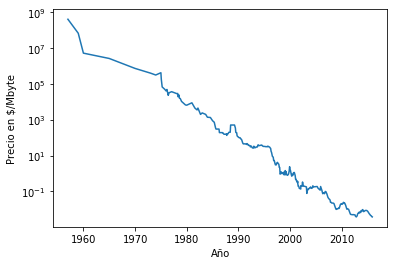

In [9]:
import os

ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Año")
plt.ylabel("Precio en $/Mbyte")
#Hay una tendencia clara

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression


# Usamos datos históricos para predecir precios después del año 2000 
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# Predecimos precios en base a fechas
X_train = data_train.date[:, np.newaxis] # Lo convertimos en vector columna con newaxis
# Usamos una transformación logarítmica para obtener
# una relación más sencilla de los datos y el objetivo 
y_train = np.log(data_train.price) # Hacemos la transformación logarítmica

tree = DecisionTreeRegressor(max_depth=3
                            ).fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# Predecimos para todos los datos
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# Deshacemos la transformación logarítmica
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

Ahora, dibujamos  las predicciones para comparar los modelos con los datos de partida:

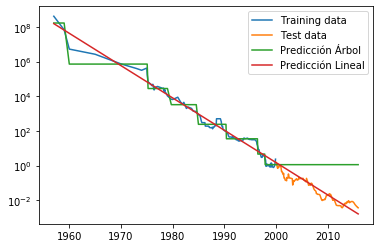

In [13]:
plt.semilogy(data_train.date,
             data_train.price, label="Training data")
plt.semilogy(data_test.date,
             data_test.price, label="Test data")
plt.semilogy(ram_prices.date,
             price_tree, label="Predicción Árbol")
plt.semilogy(ram_prices.date,
             price_lr, label="Predicción Lineal")
plt.legend()

# El árbol predice distinto, peor aún así la regresión lineal predice mejor
# Se ve que en el año 2000, el árbol se mantiene constante, como el árbol no tiene datos del rango más adelante
# de 2000, no predice bien. Es decir si la variable está fuera de rango del entrenamiento,
# es mal predicto el árbol, porqu no sabe tomar decisiones de cosas que no sabe.
# Todo lo relacionado con tendencias, el árbol de decisión no es buena.
# Tampoco es bueno el randomForest por lo mismo.

La diferencia que puede apreciarse entre el Árbol de decisión y el modelo lineal es importante.

El modelo lineal aproxima con una recta, como ya sabíamos que ocurriría, y la línea da una buena predicción de los datos de test omitiendo las variaciones de grano fino que ocurren en ambos datasets.

El árbol de decisión por el contrrio hace una predicción cuasi-perfecta en el dataset de entrenamiento. Sin embargo, una vez abandona el intervalo para el cual tiene datos, reutiliza la predicción del último datapoint del intervalo conocido para emitir predicciones en el dataset de test. El árbol no es capaz de generar respuestas nuevas fuera de lo que ha podido ver en el dataset de training. Esta limitación es de aplicación en todos los modelos basados en árbol.